In [1]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import r2_score


In [5]:
def read_one_tsv(path):
    tokens = []

    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # разбиваем по табу, если он есть
            parts = line.split("\t")

            token = parts[0].strip()
            if token and token != "_" and token.lower() != "nan":
                tokens.append(token)

    return " ".join(tokens)



def load_corpus_split(split_dir):
    # split_dir = ".../annotated-corpus/train" или test
    paths = sorted(glob.glob(os.path.join(split_dir, "*", "*.tsv")))
    texts = []
    ids = []
    labels = []

    for p in paths:
        text = read_one_tsv(p)
        texts.append(text)

        # label = папка 1..4
        lab = os.path.basename(os.path.dirname(p))
        labels.append(int(lab))

        ids.append(os.path.basename(p))

    return texts, np.array(labels), ids, paths


In [6]:
BASE_DIR = "projects/ms-pynko/assets/annotated-corpus"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR  = os.path.join(BASE_DIR, "test")

train_texts, y_train_labels, train_ids, train_paths = load_corpus_split(TRAIN_DIR)
test_texts,  y_test_labels,  test_ids,  test_paths  = load_corpus_split(TEST_DIR)

print("train docs:", len(train_texts), "classes:", np.unique(y_train_labels))
print("test docs :", len(test_texts),  "classes:", np.unique(y_test_labels))
print("пример текста:\n", train_texts[0][:300])


train docs: 120000 classes: [1 2 3 4]
test docs : 7600 classes: [1 2 3 4]
пример текста:
 Venezuelans Vote Early in Referendum on Chavez Rule ( Reuters ) . Reuters - Venezuelans turned out early \ and in large numbers on Sunday to vote in a historic referendum \ that will either remove left-wing President Hugo Chavez from \ office or give him a new mandate to govern for the next two \ ye


In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    max_features=5000,
    min_df=5,
    stop_words="english",                 # убираем the, of, to и т.п.
    token_pattern=r"(?u)\b[a-zA-Z]{3,}\b" # слова длиной ≥ 3
)

X_train_dtm = vectorizer.fit_transform(train_texts)
X_test_dtm  = vectorizer.transform(test_texts)

print(X_train_dtm.shape, X_test_dtm.shape)


(120000, 5000) (7600, 5000)


In [18]:
n_classes = len(np.unique(y_train_labels))
topics_list = [2, 5, 10, 20, 40]
if n_classes not in topics_list:
    topics_list.append(n_classes)
topics_list = sorted(topics_list)

topics_list


[2, 4, 5, 10, 20, 40]

In [19]:
from sklearn.decomposition import LatentDirichletAllocation
import time

models = {}
perplexities = []

for k in topics_list:
    print(f"\n=== LDA: n_topics={k} ===")
    t0 = time.time()

    lda = LatentDirichletAllocation(
        n_components=k,
        max_iter=20,              # базовое значение
        learning_method="batch",
        random_state=42
    )

    lda.fit(X_train_dtm)

    perp = lda.perplexity(X_test_dtm)   # perplexity НА TEST
    dt = time.time() - t0

    print(f"perplexity(test)={perp:.3f} | train_time={dt:.1f}s")

    models[k] = lda
    perplexities.append(perp)

perplexities



=== LDA: n_topics=2 ===
perplexity(test)=2679.684 | train_time=121.5s

=== LDA: n_topics=4 ===
perplexity(test)=2492.377 | train_time=117.7s

=== LDA: n_topics=5 ===
perplexity(test)=2448.940 | train_time=112.5s

=== LDA: n_topics=10 ===
perplexity(test)=2716.975 | train_time=107.4s

=== LDA: n_topics=20 ===
perplexity(test)=3246.169 | train_time=109.3s

=== LDA: n_topics=40 ===
perplexity(test)=4081.224 | train_time=115.0s


[np.float64(2679.6842417167945),
 np.float64(2492.377417202433),
 np.float64(2448.9396750700503),
 np.float64(2716.9749032467753),
 np.float64(3246.168941155195),
 np.float64(4081.224438463713)]

In [20]:
vocab = np.array(vectorizer.get_feature_names_out())

def top_words_for_model(model, vocab, n_top=10):
    topics = []
    for topic in model.components_:
        top_ids = np.argsort(topic)[-n_top:][::-1]
        topics.append(vocab[top_ids].tolist())
    return topics

all_top_words = {}

for k in topics_list:
    print(f"\n=== TOP-10 слова для k={k} ===")
    tw = top_words_for_model(models[k], vocab, n_top=10)
    all_top_words[k] = tw
    for i, words in enumerate(tw):
        print(f"Тема {i+1}: " + ", ".join(words))



=== TOP-10 слова для k=2 ===
Тема 1: said, new, reuters, company, quot, president, microsoft, year, million, corp
Тема 2: reuters, oil, new, game, stocks, prices, world, sunday, season, team

=== TOP-10 слова для k=4 ===
Тема 1: reuters, said, new, company, million, prices, percent, year, york, corp
Тема 2: game, new, season, win, team, night, world, victory, year, league
Тема 3: new, microsoft, quot, software, internet, search, space, security, web, music
Тема 4: said, reuters, oil, iraq, president, stocks, minister, afp, fullquote, bush

=== TOP-10 слова для k=5 ===
Тема 1: company, million, said, deal, new, billion, corp, internet, court, business
Тема 2: game, season, new, win, team, night, world, victory, year, league
Тема 3: new, microsoft, quot, search, space, software, security, web, google, computer
Тема 4: said, iraq, president, reuters, afp, minister, bush, people, killed, government
Тема 5: reuters, oil, new, stocks, prices, said, percent, fullquote, sales, quarter

=== TO

In [21]:
topic_probs = {}

for k in topics_list:
    lda = models[k]
    P = lda.transform(X_train_dtm)  # (n_docs, k)
    topic_probs[k] = P

    print(f"\n=== k={k} === P shape: {P.shape}")

    # по 3 самых "уверенных" документа для каждой темы
    for t in range(k):
        top_docs = np.argsort(P[:, t])[-3:][::-1]
        print(f"Тема {t+1}: docs idx {top_docs} | files {[train_ids[i] for i in top_docs]}")



=== k=2 === P shape: (120000, 2)
Тема 1: docs idx [115039 115029  60187] | files ['099285.tsv', '099237.tsv', '001061.tsv']
Тема 2: docs idx [37715 46158  1494] | files ['031509.tsv', '065917.tsv', '005861.tsv']

=== k=4 === P shape: (120000, 4)
Тема 1: docs idx [  7246   7256 102105] | files ['027628.tsv', '027686.tsv', '047020.tsv']
Тема 2: docs idx [46158 30266 52733] | files ['065917.tsv', '001694.tsv', '091846.tsv']
Тема 3: docs idx [115039 115029 112824] | files ['099285.tsv', '099237.tsv', '090156.tsv']
Тема 4: docs idx [19656 12470 12492] | files ['076675.tsv', '047930.tsv', '048004.tsv']

=== k=5 === P shape: (120000, 5)
Тема 1: docs idx [90819 88701 92620] | files ['002152.tsv', '115306.tsv', '009894.tsv']
Тема 2: docs idx [46158 52733 46967] | files ['065917.tsv', '091846.tsv', '069413.tsv']
Тема 3: docs idx [115039 115029  60187] | files ['099285.tsv', '099237.tsv', '001061.tsv']
Тема 4: docs idx [ 4239  1331 19656] | files ['016498.tsv', '005367.tsv', '076675.tsv']
Тема 5

In [22]:
np.savez("lda_topic_probs_train.npz", **{f"k_{k}": topic_probs[k] for k in topic_probs})
print("Saved: lda_topic_probs_train.npz")


Saved: lda_topic_probs_train.npz


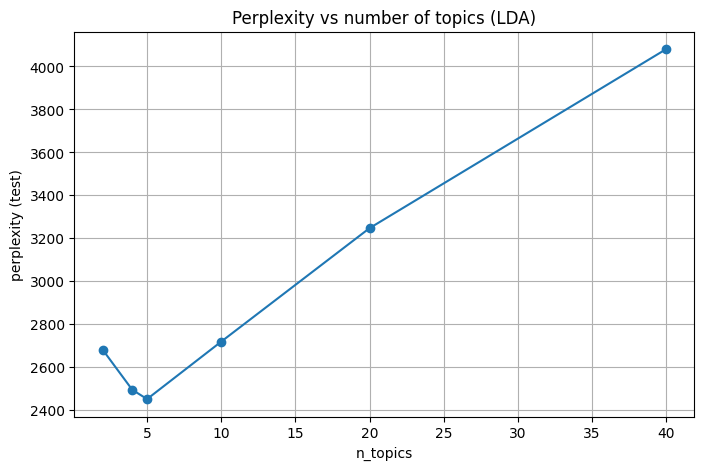

In [23]:
plt.figure(figsize=(8,5))
plt.plot(topics_list, perplexities, marker="o")
plt.xlabel("n_topics")
plt.ylabel("perplexity (test)")
plt.title("Perplexity vs number of topics (LDA)")
plt.grid(True)
plt.show()


In [24]:
from sklearn.metrics import r2_score

x = np.array(topics_list, dtype=float)
y = np.array(perplexities, dtype=float)

best_deg, best_r2, best_poly = None, -1e9, None

for deg in range(1, 8):
    coeff = np.polyfit(x, y, deg)
    poly = np.poly1d(coeff)
    y_hat = poly(x)
    r2 = r2_score(y, y_hat)
    print(f"degree={deg}: R2={r2:.4f}")
    if r2 > best_r2:
        best_r2, best_deg, best_poly = r2, deg, poly

print("\nBEST:", best_deg, "R2=", best_r2)


degree=1: R2=0.9604
degree=2: R2=0.9641
degree=3: R2=0.9872
degree=4: R2=0.9999
degree=5: R2=1.0000
degree=6: R2=1.0000
degree=7: R2=1.0000

BEST: 5 R2= 1.0


/var/folders/19/jttr67_d0wj1bx9t_nd11r900000gn/T/ipykernel_36383/2492385440.py:9: RankWarning: Polyfit may be poorly conditioned
  coeff = np.polyfit(x, y, deg)
/var/folders/19/jttr67_d0wj1bx9t_nd11r900000gn/T/ipykernel_36383/2492385440.py:9: RankWarning: Polyfit may be poorly conditioned
  coeff = np.polyfit(x, y, deg)


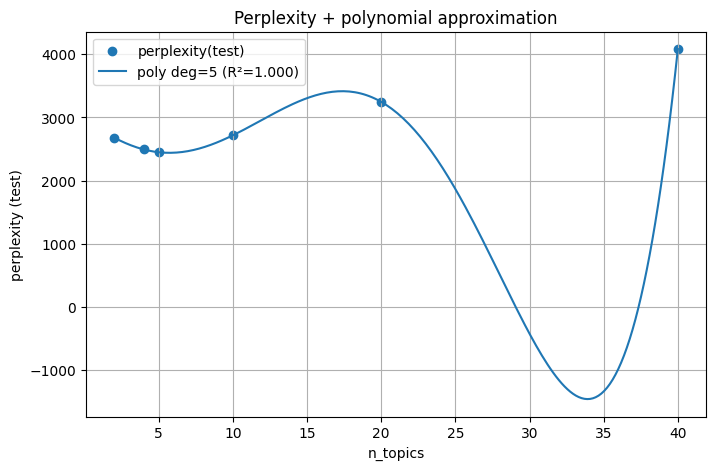

In [25]:
xx = np.linspace(x.min(), x.max(), 200)

plt.figure(figsize=(8,5))
plt.scatter(x, y, label="perplexity(test)")
plt.plot(xx, best_poly(xx), label=f"poly deg={best_deg} (R²={best_r2:.3f})")
plt.xlabel("n_topics")
plt.ylabel("perplexity (test)")
plt.title("Perplexity + polynomial approximation")
plt.grid(True)
plt.legend()
plt.show()
